#### Chain of Thoughts Implementation with RAG

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph,END
from langchain_groq import ChatGroq

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')

In [4]:
docs=TextLoader('research_notes.txt',encoding='utf-8').load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunks=splitter.split_documents(docs)
embedding_model=OpenAIEmbeddings(model='text-embedding-3-small')
vector_store=FAISS.from_documents(chunks,embedding_model)
retriever=vector_store.as_retriever()

In [5]:
llm=ChatGroq(model='gemma2-9b-it')

In [7]:
class CoTState(BaseModel):
    question:str
    sub_steps:List[str]=[]
    retrieved_docs:List[Document]=[]
    answer:str=""

In [8]:
def plan_steps(state:CoTState) -> CoTState:
    prompt=f"""Break the question into 2-3 reasoning steps: \n\n {state.question}"""
    result=llm.invoke(prompt).content
    subq=[line.strip("- ") for line in result.split('\n') if line.strip()]

    return state.model_copy(update={"sub_steps":subq})

In [9]:
def retrieve_per_step(state:CoTState) -> CoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs=retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={'retrieved_docs':all_docs})

In [10]:
def generate_answer(state:CoTState) -> CoTState:
    context="\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt=f"""
You are answering a complex question using reasoning and retrieved documents

Question:{state.question}

Relevent Information:
{context}

Now synthesize a well reasoned final answer"""
    
    result=llm.invoke(prompt).content.strip()
    return state.model_copy(update={'answer':result})

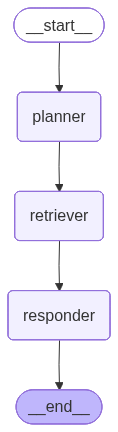

In [11]:
builder=StateGraph(CoTState)
builder.add_node("planner",plan_steps)
builder.add_node("retriever",retrieve_per_step)
builder.add_node("responder",generate_answer)
builder.set_entry_point("planner")

builder.add_edge("planner","retriever")
builder.add_edge("retriever","responder")
builder.add_edge("responder",END)

graph=builder.compile()

graph

In [12]:
if __name__=="__main__":
    query="In the context of machine translation, how does the attention mechanism improve over traditional sequence-to-sequence models, and what role does it play in handling long sentences, aligning words between languages, and reducing information loss, while also enabling Transformer architectures to scale effectively compared to recurrent models?"
    state=CoTState(question=query)
    final=graph.invoke(state)

    print("\n Reasoning Steps:",final['sub_steps'])
    print("\n Final Answer:",final['answer'])



 Reasoning Steps: ["Here's a breakdown of the question into reasoning steps:", '**Step 1:  Compare Traditional Sequence-to-Sequence Models with Attention**', '*  How do traditional sequence-to-sequence models (like RNN-based ones) handle machine translation?', '*  What are their limitations, especially when dealing with long sentences?', "**Step 2:  Explain the Attention Mechanism's Role**", '*  How does the attention mechanism work within a sequence-to-sequence framework?', '*  Specifically, how does it address the limitations of traditional models in:', '*   Handling long sentences?', '*   Aligning words between source and target languages?', '*   Reducing information loss during translation?', '**Step 3:  Connect Attention to Transformer Architectures**', '*  How does the attention mechanism contribute to the effectiveness of Transformer architectures?', '*  Why are Transformers more scalable than recurrent models for machine translation?', 'By breaking down the question this way, 